In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# =========== Veri kümesini yükleme ===========
# torchvision kütüphanesi bize birçok veri kümesini hazır bir şekilde sağlar. 
# DOC: https://pytorch.org/docs/stable/torchvision/datasets.html


# 
transform = transforms.Compose([transforms.ToTensor()]) 

# Veri kümesinin yüklenmesi
trainset = torchvision.datasets.MNIST(root='./data/MNIST', train=True, shuffle=True, download=True, transform=transform)


# Veri kümesinin hazır hale getirilmesi (batch'lere ayrılması)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4)


print(len(trainset))
print(trainset.targets)
print(trainset.classes)
print(trainset.data.size())


sample = next(iter(trainset))


image, label = sample


0it [00:00, ?it/s]

9920512it [00:05, 1781616.14it/s]                             


Extracting ./data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz


32768it [00:00, 421137.16it/s]
0it [00:00, ?it/s]

Extracting ./data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 6850250.69it/s]                           
8192it [00:00, 169001.71it/s]


Extracting ./data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz
Extracting ./data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!
60000
tensor([5, 0, 4,  ..., 5, 6, 8])
['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']
torch.Size([60000, 28, 28])


In [3]:
print(image.shape)
print(label)

torch.Size([1, 28, 28])
5


Text(0.5, 1.0, 'Label: 5')

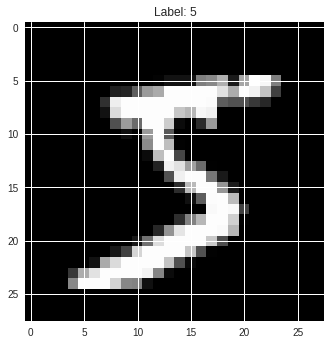

In [4]:
plt.imshow(image.squeeze(), cmap='gray')
plt.title('Label: {}'.format(label))

In [5]:
# Batch 

batch = next(iter(trainloader))
len(batch)
type(batch)

images, labels = batch

print(images.shape)
print(labels.shape)

torch.Size([4, 1, 28, 28])
torch.Size([4])


Text(0.5, 1.0, '5 - 0 - 4 - 1')

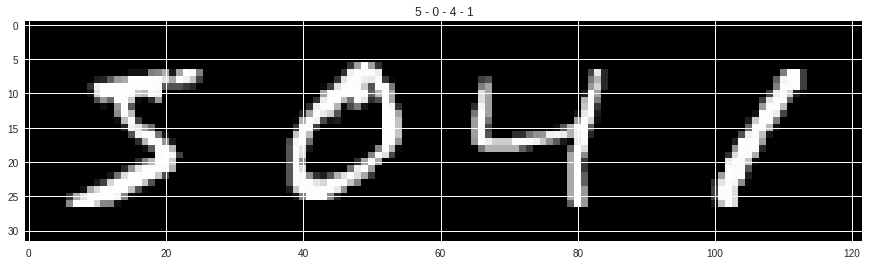

In [6]:
grid = torchvision.utils.make_grid(images, nrow=10)

plt.figure(figsize=(15,15))
plt.imshow(np.transpose(grid, (1,2,0)))

plt.title(' - '.join([str(i.item()) for i in labels]))


In [0]:

## CNN (Convolutional Neural Networks) Modelinin Oluşturulması 

import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()    
    
    # Convolutional Layer
    # conv2d(in channel, out channel, kernel size)
    self.conv1 = nn.Conv2d(1,6,5)
       
    
    # Pooling Layer
    # MaxPool2d(kernel size)
    self.pool = nn.MaxPool2d(2,2)
    
    
    # Convolutional Layer
    self.conv2 = nn.Conv2d(6,16,5)
    
    
    # Fully-Connected Layers
    self.fc1 = nn.Linear(16*16, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)
    
    
  def forward(self, x):   
    x = self.conv1(x)    
    x = F.relu(x)    
    x = self.pool(x)
    
    x = self.conv2(x)
    x = F.relu(x)
    x = self.pool(x)
    
    x = x.view(-1, 16*16)
    
    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)
    x = F.relu(x)
    x = self.fc3(x)
    
    return x

  
net = Net()


In [0]:
## Loss Fonksiyonu and Optimizer

import torch.optim as optim


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001) # lr: learning rate


In [9]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
            
            

print('Finished Training')

[1,  2000] loss: 2.299
[1,  4000] loss: 2.288
[1,  6000] loss: 2.259
[1,  8000] loss: 2.025
[1, 10000] loss: 1.081
[1, 12000] loss: 0.580
[1, 14000] loss: 0.443
[2,  2000] loss: 0.344
[2,  4000] loss: 0.332
[2,  6000] loss: 0.277
[2,  8000] loss: 0.277
[2, 10000] loss: 0.224
[2, 12000] loss: 0.226
[2, 14000] loss: 0.210
Finished Training


In [0]:
## Testing

testset = torchvision.datasets.MNIST(root='./data/MNIST', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False)


dataiter = iter(testloader)
images, labels = dataiter.next()


# print images
plt.imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))




In [14]:
outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % testset.classes[predicted[j]]
                              for j in range(4)))

Predicted:  7 - seven 2 - two 1 - one 0 - zero


In [15]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 93 %
